###  Islands: Generalized Linear Models - Chapter 4

[Back to Main Page](0_main_page.ipynb)

<br>

<h1> <center> Binary Logistic Regression </center> </h1>  

## Context

We use binary logistic regression when...

## Model

## Model

[Interested in the probability of event]

$ \large \hat{P}_{(y_{i} = 1)} = \hat\pi_{1i}$ 

$ \large \hat{P}_{(y_{i} = 0)} = 1 - \hat\pi_{1i} $

We could also write this as (to save writing the probability out):

$ \large \hat{P}_{(y_{i} = 0)} =\hat\pi_{0i} $

[show whole prediction equation]

$ \large \hat{y}_{i} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_i = b_{0} + b_{i}x_{11} \dots + b_{k}x_{ki} $

The individual prediction ($\hat{y_i}$), for all $n$ observations, using $k$ variables as predictors are:

$$ \large \hat{y}_{1} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_1 = b_{0} + b_{1}x_{11} \dots + b_{k}x_{k1} $$

$$ \large \hat{y}_{2} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_2 = b_{0} + b_{1}x_{12} \dots + b_{k}x_{k2} $$

$$ \large \hat{y}_{3} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_3 = b_{0} + b_{1}x_{13} \dots + b_{k}x_{k3} $$

$$ \dots $$

$$ \large \hat{y}_{n} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_n = b_{0} + b_{1}x_{1n} \dots + b_{k}x_{kn} $$

[explanation of above formulas, element by element here]

$$
\Large \begin{bmatrix}
           {\hat{y}_{1}} \\
           {\hat{y}_{2}} \\
           {\hat{y}_{3}} \\
           \vdots \\
           {\hat{y}_{n}}
         \end{bmatrix} = \begin{bmatrix}
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_1 } \\
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_2 } \\
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_3 }  \\
           \vdots \\
           {\ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_n}
         \end{bmatrix} = \begin{bmatrix}
           {1} & {x_{11}} & \dots & {x_{k1}}\\ 
           {1} & {x_{12}} & \dots & {x_{k2}}\\ 
           {1} & {x_{13}} & \dots & {x_{k3}}\\ 
           \vdots & \vdots & \vdots & \vdots\\
           {1} & {x_{1n}} & \dots & {x_{kn}} \\ 
         \end{bmatrix} \begin{bmatrix}
           {b_{0}} \\ 
           \vdots \\
           {b_{k}} \\ 
         \end{bmatrix} 
$$


$ \large \hat\pi_{1i} =  \frac{e^{\hat{y}_{i}}}{1 + e^{\hat{y_{i}}}}$ 

$ \large \hat\pi_{0i} = 1 - \hat\pi_{1i} $


## Parameter Estimation

[define indicotr variables as piecewise function]

The model gets its parameters, by maximizing:

$ \large \prod  \hat\pi_{0i}^{\text{indicator}_{0i}}  \hat\pi_{1i}^{\text{indicator}_{1i}}  $


Equivalently, by minimizing (has the same effect, but easier for a computer to work with):

$ \large - \sum \text{indicator}_{0i} \cdot ln(\hat\pi_{0i}) + \text{indicator}_{1i} \cdot ln(\hat\pi_{1i}) $

[Explain this with numbers at the level of individual scores]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import islands_GLM

islands_GLM.r_ify()

C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
slopes =  [-5, 0.89] # <-- this works!

pop_size = 100

number_of_social_contacts = np.random.gamma(5, size = pop_size) 

number_of_social_contacts[number_of_social_contacts > np.quantile(number_of_social_contacts, .25)] = number_of_social_contacts[number_of_social_contacts > np.quantile(number_of_social_contacts, .25)] + np.abs(np.random.normal(0, 5, size = len(number_of_social_contacts[number_of_social_contacts > np.quantile(number_of_social_contacts, .25)])))
        
drug_type = np.random.choice([0,1], p = [0.5, 0.5], size = pop_size) 

linear_predictor =  slopes[0] * number_of_social_contacts + slopes[1] * drug_type + np.random.normal(0, 20, size = pop_size)

addiction_p = (np.exp(linear_predictor))/(1 + np.exp(linear_predictor))

addiction_status = np.repeat('', len(addiction_p))
addiction_status = np.where(addiction_p >= 0.5, 'addict', addiction_status)
addiction_status = np.where(addiction_p < 0.5, 'not_addict', addiction_status)

        
df = pd.DataFrame({'number_of_social_contacts': number_of_social_contacts.astype('int'), 'drug_type': drug_type,
                   'addiction_status': addiction_status})

df['addiction_dummy'] =  df['addiction_status'].replace(['addict', 'not_addict'], [1,0])

display(df)



,number_of_social_contacts,drug_type,addiction_status,addiction_dummy
0,11,0,not_addict,0
1,6,0,not_addict,0
2,17,1,not_addict,0
3,9,0,not_addict,0
4,1,1,not_addict,0
...,...,...,...,...
95,9,1,not_addict,0
96,12,1,not_addict,0
97,10,1,not_addict,0
98,2,0,not_addict,0


In [3]:
df['addiction_dummy'] =  df['addiction_status'].replace(['addict', 'not_addict'], [1,0])

df

,number_of_social_contacts,drug_type,addiction_status,addiction_dummy
0,11,0,not_addict,0
1,6,0,not_addict,0
2,17,1,not_addict,0
3,9,0,not_addict,0
4,1,1,not_addict,0
...,...,...,...,...
95,9,1,not_addict,0
96,12,1,not_addict,0
97,10,1,not_addict,0
98,2,0,not_addict,0


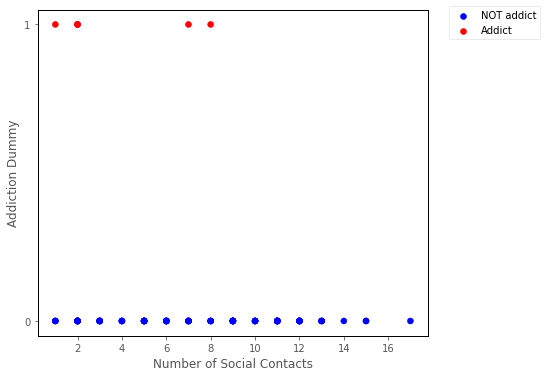

In [4]:
addiction_color = {0: 'blue',
              1: 'red'}

fig, ax = plt.subplots()
ax.scatter(df['number_of_social_contacts'], df['addiction_dummy'] , c = df['addiction_dummy'].map(addiction_color))
ax.set_yticks([0,1])
ax.set_ylabel('Addiction Dummy')
ax.set_xlabel('Number of Social Contacts')
ax.scatter([], [], color = 'blue', label = 'NOT addict' )
ax.scatter([], [],  color = 'red', label = 'Addict')

plt.legend(bbox_to_anchor = (1.3,1.025))
plt.show()

## Implementation

[show with minimize here]

In [5]:
mod = sm.Logit(df['addiction_dummy'], sm.add_constant(df['number_of_social_contacts'])).fit()

mod.summary()

C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.197275
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        addiction_dummy   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jun 2022   Pseudo R-squ.:                  0.1308
Time:                        15:54:17   Log-Likelihood:                -19.728
converged:                       True   LL-Null:                       -22.697
Covariance Type:            nonrobust   LLR p-value:                   0.01481
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.0485      0.747     -1.403      0.161      -2.514       0.417
number_of_social_contacts    -0.3201      0.159     -2.018      0.044      -0.631      -0.009
=============================================================================================
"""

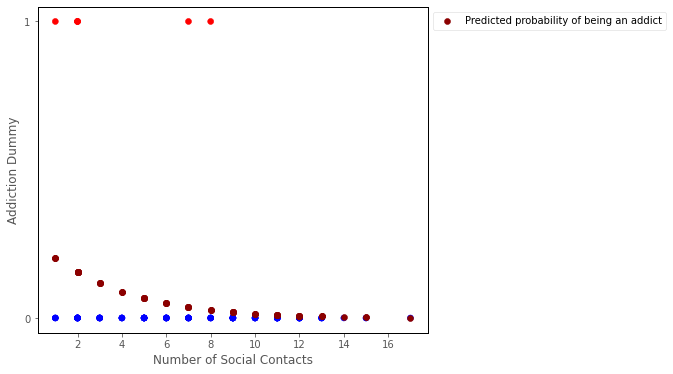

In [6]:
log_odds_predictions_1 = mod.params.loc['const'] +  mod.params.loc['number_of_social_contacts'] * df['number_of_social_contacts']


probability_predictions_1 = np.exp(log_odds_predictions_1)/(1 + np.exp(log_odds_predictions_1))

addiction_color = {0: 'blue',
              1: 'red'}

fig, ax = plt.subplots()
ax.scatter(df['number_of_social_contacts'], df['addiction_dummy'] , c = df['addiction_dummy'].map(addiction_color))
ax.set_yticks([0,1])
ax.set_ylabel('Addiction Dummy')
ax.set_xlabel('Number of Social Contacts')
ax.scatter(df['number_of_social_contacts'], probability_predictions_1, color = 'darkred', label = 'Predicted probability of being an addict')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

## Interpretation (one predictor model)


## SHOW CLASSIC LOGISTIC S SHAPE HERE FOR BIVARIATE CASE

## Multi-predictor binary logistic regression

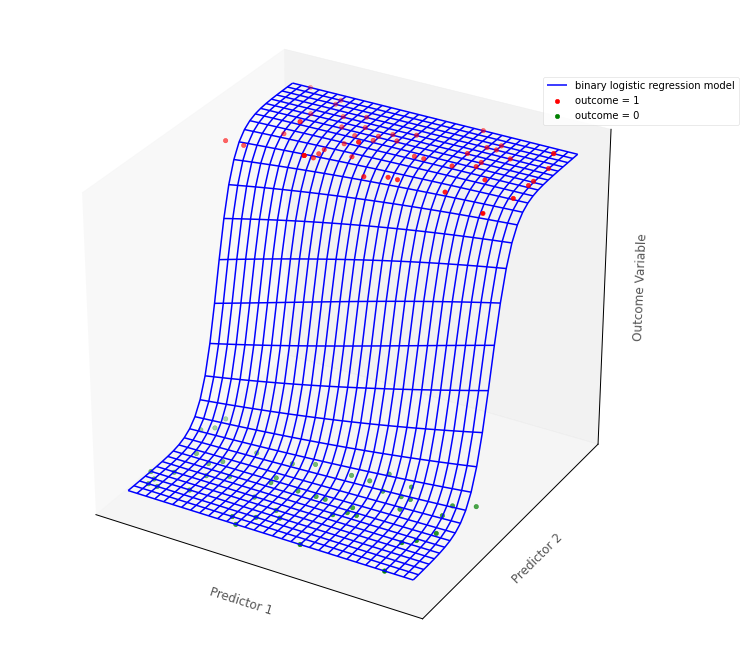

In [7]:
# show how binary logistic regression works in multiple dimensions

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x_slope = 0.2
y_slope = 3
 
x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
y = x.copy().T # transpose
lin_pop_z = x_slope*x + y_slope*y
z = np.exp(lin_pop_z)/(1 + np.exp(lin_pop_z))

data_x = np.random.choice(np.linspace(-3, 3, 32), size = 100)
data_y = np.random.choice(np.linspace(-3, 3, 32), size = 100)
lin_pred = x_slope*data_x + y_slope*data_y + np.random.normal(0, 0.3, size = 100)
data_z = (np.exp(lin_pred))/(1 + np.exp(lin_pred))
data_z = np.where(data_z >= 0.5, 1, 0)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(x,y,z, color = 'blue', label = 'binary logistic regression model')
ax1.scatter(data_x[data_z >= 0.5], data_y[data_z >= 0.5], data_z[data_z >= 0.5], color = 'red', label = 'outcome = 1')
ax1.scatter(data_x[data_z < 0.5], data_y[data_z < 0.5], data_z[data_z < 0.5], color = 'green', label = 'outcome = 0'  )
ax1.set_zticks([0,1])
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
ax1.set_zlabel('Outcome Variable')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
plt.legend(bbox_to_anchor = (1.1,0.9))
plt.show()

In [8]:
import statsmodels.formula.api as smf

mod3 = sm.Logit(df['addiction_dummy'], sm.add_constant(df[['number_of_social_contacts', 'drug_type']])).fit()

mod3.summary()

Optimization terminated successfully.
         Current function value: 0.197142
         Iterations 8


C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        addiction_dummy   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Jun 2022   Pseudo R-squ.:                  0.1314
Time:                        15:54:17   Log-Likelihood:                -19.714
converged:                       True   LL-Null:                       -22.697
Covariance Type:            nonrobust   LLR p-value:                   0.05066
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.9561      0.937     -1.020      0.308      -2.793       0.881
number_of_social_contacts    -0.3251      0.164     -1.986      0.047      -0.646      -0.004
drug_type                    -0.1445      0.886     -0.163      0.870      -1.882       1.592
=============================================================================================
"""

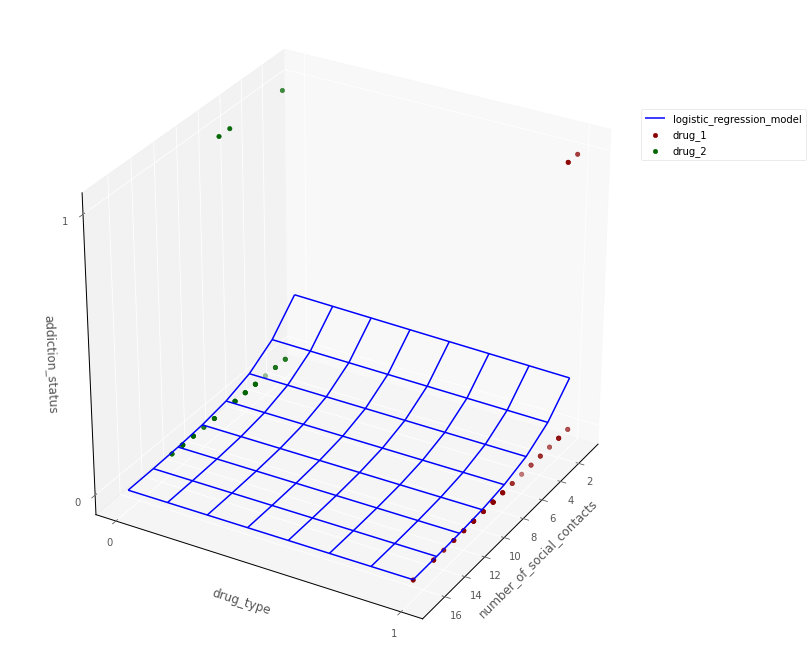

In [9]:
intercept, number_of_social_contacts_slope, drug_type_slope = mod3.params[:3]

def three_D_model_plot(x_name, y_name, z_name, intercept, x_slope, y_slope, df, model_name, y1_name, y2_name):
    group_1 = df[df[y_name] == 1]
    group_2 = df[df[y_name] == 0]
    x = np.linspace(np.min(df[x_name]), np.max(df[x_name]), 8)
    y = np.linspace(np.min(df[y_name]), np.max(df[y_name]), 8)
    x, y = np.meshgrid(x, y)
    
    if model_name == 'linear_regression_model':
        z = intercept + x_slope * x.ravel() + y_slope * y.ravel()
    
    if model_name == 'poisson_regression_model':
        z = np.exp(intercept + x_slope * x.ravel() + y_slope * y.ravel())
        
    if model_name == 'logistic_regression_model':
        z = (np.exp(intercept + x_slope * x.ravel() + y_slope * y.ravel()))/(1 + np.exp(intercept + x_slope * x.ravel() + y_slope * y.ravel()))

    fig = plt.figure(figsize = (12, 12))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_wireframe(x, y,
                    z.reshape(x.shape), label = model_name, color = 'blue')
    ax1.scatter( group_1[x_name],  group_1[y_name] ,  group_1[z_name], color = 'darkred', label = y1_name  )
    ax1.scatter(group_2[x_name],  group_2[y_name] ,  group_2[z_name], color = 'darkgreen', label =  y2_name  )
    ax1.view_init(azim = 30)
    ax1.set_yticks([0,1])
    ax1.set_zticks([0,1])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    if model_name == 'logistic_regression_model':
        ax1.set_zlabel('addiction_status')
    else:
        ax1.set_zlabel(z_name)
    ax1.legend(bbox_to_anchor = (1.2,0.85))
    plt.show()
    
three_D_model_plot('number_of_social_contacts', 'drug_type', 
                   'addiction_dummy', intercept, number_of_social_contacts_slope, drug_type_slope,
                  df, 'logistic_regression_model', 'drug_1', 'drug_2')

## Interpretation (multiple predictors)

The coefficient of each predictor tells us the predicted difference in the outcome variable scores for two observations which differed *only* by a one unit score in that predictor. E.g. which had the same score on all other predictors.

The intercept tells us the predicted score on the outcome variable for an observation whose score on all other predictors was 0. 

## Statistical interaction in Binary Logistic Regression

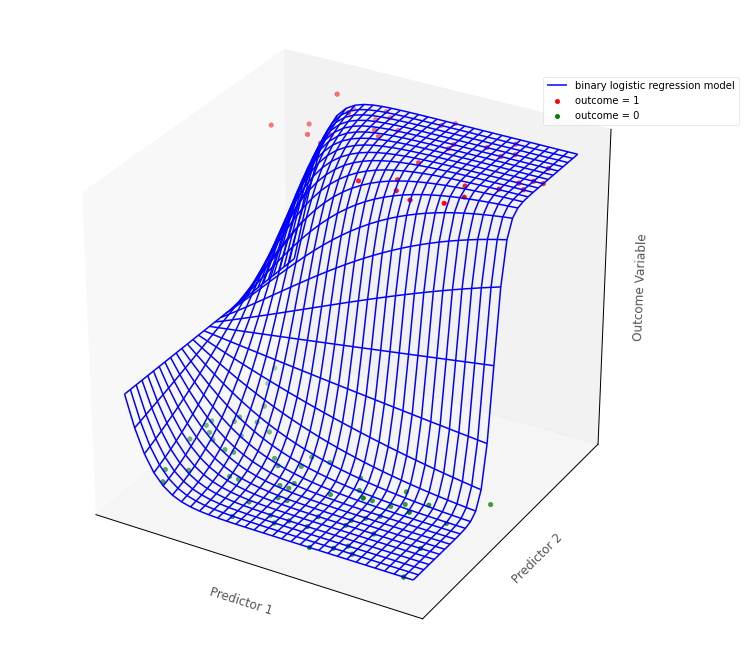

In [12]:
x_slope = 0.2
y_slope = 3
 
x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
y = x.copy().T # transpose
lin_pop_z = x_slope*x + y_slope*y + 1*x*y
z = np.exp(lin_pop_z)/(1 + np.exp(lin_pop_z))

data_x = np.random.choice(np.linspace(-3, 3, 32), size = 100)
data_y = np.random.choice(np.linspace(-3, 3, 32), size = 100)
lin_pred = x_slope*data_x + y_slope*data_y + 1*data_x*data_y + np.random.normal(0, 0.3, size = 100)
data_z = (np.exp(lin_pred))/(1 + np.exp(lin_pred))
data_z = np.where(data_z >= 0.5, 1, 0)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(x,y,z, color = 'blue', label = 'binary logistic regression model')
ax1.scatter(data_x[data_z >= 0.5], data_y[data_z >= 0.5], data_z[data_z >= 0.5], color = 'red', label = 'outcome = 1')
ax1.scatter(data_x[data_z < 0.5], data_y[data_z < 0.5], data_z[data_z < 0.5], color = 'green', label = 'outcome = 0'  )
ax1.set_zticks([0,1])
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
ax1.set_zlabel('Outcome Variable')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
plt.legend(bbox_to_anchor = (1.1,0.9))
plt.show()

## Other Chapters

1. [What are Generalized Linear Models?](1_generalized_linear_models.ipynb)
2. [Linear Regression](2_linear_regression.ipynb)
3. [Poisson Regression](3_poisson_regression.ipynb)
4. [Binary Logistic Regression](4_binary_logistic_regression.ipynb)
5. [Multinomial Logistic Regression](5_multinomial_logistic_regression.ipynb)

***
By [pxr687](99_about_the_author.ipynb) 